In [1]:
import numpy as np
import pandas as pd
import sqlite3
import datetime
from matplotlib import pyplot as plt

from collections import Counter

# from spacy.lang.en import English
# nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
# tokenizer = nlp.tokenizer
# num_tok = len(tokenizer(my_string))

In [2]:
# imports for rpy2 to run glmer from lme4 for logistic m-e model

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')

In [61]:
flow_df = pd.read_csv('data/New_flow_1_2020.csv')
FLOW_LEN = 29

# Start Discard here!

In [3]:
suff = '5feb2021'
dbname = 'data/session_info_feb5.db'

workbookname = 'data/sona_convos_annotated_%s.xlsx' % suff
surveyfilename = 'data/Questions_baseline_chatbot_February 5, 2021_16.06.csv'

In [4]:
cur = sqlite3.connect(dbname).cursor()

In [5]:
# load survey data sheet
raw_survey_df = pd.read_csv(surveyfilename)
survey_question_text_ts = raw_survey_df.loc[0]
raw_survey_df[:5]

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,...,Q255_2,Q255_3,Q255_4,Q255_5,Q255_6,Q58,Q57,SC0,SC2,id
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,If at any point you wanted to leave the conver...,Thank you for participating in our study. If y...,Score,PHQ-8 Patient Health Questionnaire- 8items,id
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}",...,"{""ImportId"":""QID311_2""}","{""ImportId"":""QID311_3""}","{""ImportId"":""QID311_4""}","{""ImportId"":""QID311_12""}","{""ImportId"":""QID311_13""}","{""ImportId"":""QID321_TEXT""}","{""ImportId"":""QID320_TEXT""}","{""ImportId"":""SC_by0GhYnW8z2dcq1""}","{""ImportId"":""SC_6gkccQmPIhIRJM9""}","{""ImportId"":""id""}"
2,2020-11-06 00:40:59,2020-11-06 00:45:57,Survey Preview,100,298,True,2020-11-06 00:45:58,R_1rAOxkXtOyiprCR,preview,EN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,6,NaN
3,2020-11-06 01:05:24,2020-11-06 01:08:11,Survey Preview,100,167,True,2020-11-06 01:08:13,R_O2mBVurRhoHtoHv,preview,EN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,17,NaN
4,2020-12-01 12:15:36,2020-12-01 12:15:36,Survey Test,100,0,True,2020-12-01 12:15:36,R_d1rrLLibNXatf6J,test,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,15,NaN


In [12]:
# load conversation sheets
convos = pd.read_excel(workbookname, engine='openpyxl', sheet_name=None)
convo_ids = list(convos.keys())

In [13]:
print('Example convo ids: ', convo_ids[:5])
convos[convo_ids[10]][:5]

Example convo ids:  ['9244_22cee091', '50081_a05ac73b', '50321_27d7083e', '38917_bca8e1ae', '46238_3e041c3a']


,Flow Index,User Message,Bot Response,helpful,error,why_leave
0,0,START,"Hi, it’s great to meet you!",1.0,NaN,na
1,1,How are you?,How are you doing?,NaN,1.0,na
2,2,I am alright. Feeling a little down :(,I've heard that many people stay at home more ...,1.0,NaN,na
3,3,Yes,I see. I've also heard that many people's diet...,1.0,NaN,na
4,4,I don't think so,Ok. These last few months have been really dif...,1.0,NaN,na


### Calculate statistics on conversations & annotations

In [347]:
convo_stats = [] # these are statistics on each participant's converstion 
# flow_stats = [] # these are statistics on each flow message


for cid in convo_ids: 
    
    sona, sid = cid.split('_')
    
    
    if len(sona) != 5:
        print('Admin testing system, omitting: ', cid)
        # Not a valid SONA (5 digit intiger), likely admin testing sona 9244
        continue
        
    if sona in ['38917', '46238', '50321', '50081']:
        print('Was in pilot, omitting: ', cid)
        # This was a pilot conversation before we changed the binary "want to leave" to multiple choice "why leave" question
        continue
        
        
    results = cur.execute('select sid, joined_time from session_meta_data where pid=="%s"' % sona).fetchall()
    [convo_joined_time,] = [int(x[1]) for x in results if x[0].startswith(sid)]
    
    convo = convos[cid]
    num_messages = convo.shape[0]
    stopped_early = num_messages < FLOW_LEN
    
    # Counts of likes, errors, leave
    num_helpful = convo['helpful'].sum()
    num_error = convo['error'].sum()
    num_leave = (convo['why_leave'].dropna() != 'na').sum()
    
    # When indicated a desire to leave? 
    want_to_leave = convo['why_leave'].dropna() != 'na'
    
    # When and why first leave?
    if (want_to_leave.sum() < 1) and stopped_early:
        # note that user did not finish flow, but also did not annotate a reason for wanting to leave early
        first_leave = num_messages-1
        why_first_leave = 'no_justification'
        
    else:
        first_leave = convo['why_leave'].dropna()[want_to_leave].index.min()
        why_first_leave = convo['why_leave'][first_leave] if first_leave is not np.nan else 'complete_convo'
    
    # Error to leave? How long after the first error did they want to leave?
    first_error = convo['error'].dropna().index.min()
    error_to_leave = first_leave - first_error
    error_before_leave = first_error < first_leave
    error_is_leave = first_error == first_leave
    
    # participant engagement: how much participant wrote in conversation
    message_tok = [len(tokenizer(x)) if x is not np.nan else 0 for x in convo['User Message'][1:].values]
    avg_message_tok = np.mean(message_tok)
    tot_message_tok = np.sum(message_tok)
    
    
    
    convo_stats.append([cid, sona, sid, datetime.datetime.fromtimestamp(convo_joined_time), 
                        num_messages, stopped_early, num_helpful, num_error, num_leave, 
                        first_leave, why_first_leave, first_error, error_to_leave, 
                        error_before_leave, error_is_leave,
                        avg_message_tok, tot_message_tok])
    
#     What kinds of messages did people dis/like
#     Is the effect of errors worse for people who are more depressed/anxious?
#     Was the bot more likely to make mistakes on certain messages?
#     Were mistakes more common for certain message types? Were certain types more helpful?
#     Did certain people like/prefer certain types of messages? E.g., depressed people prefer chatting to tips
#     Length of response to flow message

raw_convo_stats_df = pd.DataFrame(convo_stats, columns = ['cid', 'sona', 'session_id', 'convo_joined_datetime', 
                                                      'num_messages', 'stopped_early', 'num_helpful', 'num_error', 'num_leave', 
                                                     'first_leave', 'why_first_leave', 'first_error', 'error_to_leave', 
                                                      'error_before_leave', 'error_is_leave', 
                                                      'avg_message_tok', 'tot_message_tok'])

Admin testing system, omitting:  9244_22cee091
Was in pilot, omitting:  50081_a05ac73b
Was in pilot, omitting:  50321_27d7083e
Was in pilot, omitting:  38917_bca8e1ae
Was in pilot, omitting:  46238_3e041c3a


In [352]:
print('DF dimensions: ', convo_stats_df.shape)
convo_stats_df[:5]

DF dimensions:  (132, 16)


,cid,sona,session_id,convo_joined_datetime,num_messages,num_helpful,num_error,num_leave,first_leave,why_first_leave,first_error,error_to_leave,error_before_leave,error_is_leave,avg_message_tok,tot_message_tok
0,50375_82125de0,50375,82125de0,2021-01-27 09:44:29,29,0.0,4.0,0,NaN,complete_convo,13.0,NaN,False,False,3.928571,110
1,45644_643fcbec,45644,643fcbec,2021-01-27 10:16:35,19,5.0,2.0,1,18.0,nofeedback,10.0,8.0,True,False,22.611111,407
2,41923_87b34bf0,41923,87b34bf0,2021-01-27 10:47:48,29,16.0,10.0,6,4.0,nolisten,4.0,0.0,False,True,3.428571,96
3,51190_8d0fe287,51190,8d0fe287,2021-01-27 11:07:59,29,28.0,1.0,6,2.0,nocare,7.0,-5.0,False,False,8.035714,225
4,44598_937c2601,44598,937c2601,2021-01-27 11:06:01,28,5.0,0.0,0,NaN,complete_convo,NaN,NaN,False,False,13.148148,355


### Add a datetime column to survey responses so response time can be compared with conversation time

In [353]:
for i in raw_survey_df.index:
    try:
        raw_survey_df.loc[i, 'EndDate_datetime'] = datetime.datetime.strptime(raw_survey_df.loc[i, 'EndDate'], '%Y-%m-%d %H:%M:%S')
    except:
        pass

### Drop duplicate annotated conversations and survey responses for participants
Make sure to end up with one annotated convo and one survey response for each participant

if two conversations are annotated, drop the one that happened later in time


if two survey responses:

    * if one is 'Finished', drop the other
    * else take the one closer in time to the conversation

In [354]:
survey_df = raw_survey_df.copy()
convo_stats_df = raw_convo_stats_df.copy()

print('Start convo dim:', convo_stats_df.shape)
print('Start survey dim:', survey_df.shape)

drop_cids = []

for sona in convo_stats_df['sona'].unique():
    s = survey_df[survey_df['id'] == sona]
    a = convo_stats_df[convo_stats_df['sona'] == sona]
    
    # If more than two annotated conversations, drop later one
    if a.shape[0] > 1: 
        # index of last conversation: 
        dropidx = a['convo_joined_datetime'].idxmax()
        
        print('Dropping extra annoated convo for sona ', sona)
        cid = convo_stats_df.loc[dropidx, 'cid']
        convo_stats_df.drop(index=dropidx, inplace=True)
        drop_cids.append(cid)
        
        
    if s.shape[0] > 1: 
        if sum(s['Finished'] == 'True') == 1:
            
            # index of the non-finished survey response
            dropidx = s[s['Finished'] == 'False'].index
            reason = 'unfinished'
        else:
            
            # list of indices for survey rows for participant
            idxs = s.index

            # calculate absolute time distance of survey response to conversation
            time_dists = [abs((x - a['convo_joined_datetime'].values[0]).total_seconds()) for x in s['EndDate_datetime']]
            
            # rows to drop from survey dataframe are those NOT closest to annotations
            dropidx = idxs[time_dists != np.min(time_dists)]
            reason = 'less close in time'
        
        print('Dropping extra survey response for sona %s because %s' % (sona, reason))
        survey_df.drop(index=dropidx, inplace=True)
        
print('End convo dim:', convo_stats_df.shape)
print('End survey dim:', survey_df.shape)
print('Dropped conversations with cids:', drop_cids)


Start convo dim: (133, 17)
Start survey dim: (215, 78)
Dropping extra survey response for sona 44692 because less close in time
Dropping extra survey response for sona 51389 because unfinished
Dropping extra survey response for sona 50638 because less close in time
Dropping extra survey response for sona 48240 because unfinished
Dropping extra survey response for sona 45566 because unfinished
Dropping extra survey response for sona 48169 because unfinished
Dropping extra annoated convo for sona  46440
Dropping extra survey response for sona 46440 because unfinished
Dropping extra survey response for sona 48039 because less close in time
Dropping extra survey response for sona 47727 because unfinished
Dropping extra survey response for sona 44600 because unfinished
Dropping extra survey response for sona 50082 because unfinished
Dropping extra survey response for sona 45849 because unfinished
Dropping extra survey response for sona 49423 because less close in time
Dropping extra survey 

# Make participant data frame

### Aggregate survey and conversation records

In [358]:
participant_df = survey_df.merge(convo_stats_df, left_on='id', right_on='sona', how='right')
participant_df.shape

(132, 95)

In [557]:
# Uncomment to print column names & question text, if desired:

# for i in participant_df.columns:
#     if i in survey_question_text_ts.index:
#         print('%s\t%s' % (i, survey_question_text_ts[i].replace('\n', ' ')))
#     else:
#         print('%s\t%s' % (i,i))

participant_df['start_gad_1'].unique()

array(['Several days', 'Not at all', 'Nearly every day',
       'More than half the days'], dtype=object)

### Rename columns and convert types

In [668]:
# 'Q249_1': mood before chat?
# 'Q55_1': mood after chat?

for col in ['SC0', 'SC2', 'Q249_1','Q55_1']:
    participant_df[col] = participant_df[col].astype(float)
    
    
# participant_df['phq8'] = participant_df['SC2'] # this included start_phq8_prd, which shouldn't be added in?
# calculate phq8 for each participant:
phq8_options = ['Not at all', 'Several days', 'More than half the days', 'Nearly every day']
for i in participant_df.index:
    participant_df.loc[i, 'phq8'] = 0
    for col in ['start_phq8_%s' % x for x in range(1,9)]:
        participant_df.loc[i, 'phq8'] += phq8_options.index(participant_df.loc[i, col])
        
        
    participant_df.loc[i, 'gad'] = 0
    for col in ['start_gad_%s' % x for x in range(1, 3)]:
        participant_df.loc[i, 'gad'] += phq8_options.index(participant_df.loc[i, col])


participant_df['mood_before'] = participant_df['Q249_1']
participant_df['mood_after'] = participant_df['Q55_1']
participant_df['mood_change'] = participant_df['mood_after'] - participant_df['mood_before']

participant_df['mood_improved'] = (participant_df['mood_change'] > 0)
participant_df['mood_unchanged'] = (participant_df['mood_change'] == 0)
participant_df['mood_worsened'] = (participant_df['mood_change'] < 0)    
    


# Q242: Have you ever chatted with a chatbot?
# Q251: Have you ever used a chatbot for mental health?
# Q219: how hard to imagine mood?
participant_df['chatbot_experience'] = participant_df['Q242'] == 'Yes'
participant_df['chatbot_mh_experience'] = participant_df['Q251'] == 'Yes'
participant_df['cant_imagine_mood'] = participant_df['Q219'] == 'Not at all'



likert_options = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']


# post chat survey on perception
temp = '''post_survey_9_1
post_survey_9_2
post_survey_9_3
post_survey_9_4
post_survey_9_5'''
quality_cols = temp.split('\n')


temp = '''post_survey_10_1
post_survey_10_2
post_survey_10_3
post_survey_10_4
post_survey_10_5
post_survey_10_6'''
utility_cols = temp.split('\n')


positive_perception_cols = quality_cols + utility_cols



# post chat survey on concerns with a chatbot
temp = '''Q255_1
Q255_2
Q255_3'''
concern_cols = temp.split('\n')

# openess to talking to a bot
temp='''Q255_4
Q255_5
Q255_6'''
open_to_bot_cols = temp.split('\n')



for i in participant_df.index:
        
    for measure_name, measure_cols in (('positive_perception', positive_perception_cols),
                                       ('quality', quality_cols),
                                       ('utility', utility_cols),
                                      ('concern', concern_cols),
                                      ('open_to_bot', open_to_bot_cols)):
        temp = 0
        for col in measure_cols:
            temp += likert_options.index(participant_df.loc[i,col])
        participant_df.loc[i, measure_name] = temp
    
    
    participant_df.loc[i, 'centered_utility'] = participant_df.loc[i, 'utility'] - 12 # best score is 24.
    participant_df.loc[i, 'less_stressed_after'] = likert_options.index(participant_df.loc[i,'post_survey_10_4'])

    
#     positive_perception = 0    
#     for col in positive_perception_cols:
#         positive_perception += likert_options.index(participant_df.loc[i, col])
    
#     concern = 0
#     for col in concern_cols:
#         concern += likert_options.index(participant_df.loc[i, col])
    
#     open_to_bot = 0
#     for col in open_to_bot_cols:
#         open_to_bot += likert_options.index(participant_df.loc[i, col])
        
#     participant_df.loc[i, 'positive_perception'] = positive_perception
#     participant_df.loc[i, 'concern'] = concern
#     participant_df.loc[i, 'open_to_bot'] = open_to_bot

## Helper column transforms

In [669]:

# set new col to null value
participant_df['left_after'] = participant_df['num_messages'] # Total messages in conversation
for i in participant_df[~np.isnan(participant_df['first_leave'])].index: 
    # set observations to observed
    participant_df.loc[i, 'left_after'] = participant_df.loc[i, 'first_leave'] 
    
# set new col to null value
participant_df['num_before_error'] = participant_df['num_messages'] # Total messages in conversation 
for i in participant_df[~np.isnan(participant_df['first_error'])].index: 
    # set observations to observed
    participant_df.loc[i, 'num_before_error'] = participant_df.loc[i, 'first_error'] 



### Threshold depression

In [670]:
participant_df['minimal_phq8'] = participant_df['phq8'] < 5
participant_df['mild_phq8'] = (5 <= participant_df['phq8']) & (participant_df['phq8'] < 10)
participant_df['moderate+_phq8'] = 10 <= participant_df['phq8']

# participant_df['depressed'] = participant_df['phq8'] >= 10
# participant_df['not_depressed'] = participant_df['phq8'] <= 5

# depressed_sonas_df = participant_df[participant_df['depressed']][['sona']]
# not_depressed_sonas_df = participant_df[participant_df['not_depressed']][['sona']]

phq8_buckets = ['minimal_phq8', 'mild_phq8', 'moderate+_phq8']
phq8_sona_dfs = {}
phq8_dfs = {}
for col in phq8_buckets:
#     phq8_sona_dfs[col] = participant_df[participant_df[col]][['sona']]
    phq8_dfs[col] = participant_df[participant_df[col]]

# Make message level dataframe

In [671]:
flow_df = pd.read_csv('data/New_flow_1_2020.csv')

# clean up typo in strategy naming
typo_inds = flow_df['strategy_fixed'][flow_df['strategy_fixed'] == 'active listening'].index
for i in typo_inds:
    flow_df.loc[i, 'strategy_fixed'] = 'active_listening'

# shorten column name for convenience, clarity
flow_df['strategy'] = flow_df['strategy_fixed']

In [672]:
convo_dfs = [] # these are statistics on each participant's converstion 


for cid in participant_df['cid'].values: 
    
    sona, sid = cid.split('_')
    
    
    convo = convos[cid]
    
    # convert annotation checkboxes to booleans
    convo['helpful_bool'] = ~np.isnan(convo['helpful'])
    convo['error_bool'] = ~np.isnan(convo['error'])
    convo['leave_bool'] = convo['why_leave'] != 'na'

    
    # indicate first want to leave message
    stopped_early = convo.shape[0] < FLOW_LEN
    if stopped_early and convo.loc[convo.index.max(), 'why_leave'] == 'na':
        # Indicate there was no justification, despite the participant leaving early
        convo.loc[convo.index.max(), 'why_leave'] = 'no_justification'
    
    want_to_leave = convo['why_leave'].dropna() != 'na'
    first_leave = convo['why_leave'].dropna()[want_to_leave].index.min()
    temp = [False]*convo.shape[0]
    if ~np.isnan(first_leave):
        temp[first_leave] = True
    convo['first_leave'] = temp
    
    
    
    # indicate first response error
    first_error = convo['error'].dropna().index.min()
    temp = [False]*convo.shape[0]
    if ~np.isnan(first_error):
        temp[first_error] = True
    convo['first_error'] = temp
    
    
    # participant engagement: how much participant wrote in conversation
    message_tok = [len(tokenizer(x)) if x is not np.nan else 0 for x in convo['User Message'].values]
    convo['user_message_len'] = message_tok
    

    # add participant identification
    convo['sona'] = sona
    convo['cid'] = cid
    
    
    # Join to append the message strategy
    convo = convo.merge(flow_df[['strategy']], how='left', left_on='Flow Index', right_index=True)
    
    
    convo_dfs.append(convo)
    
    
message_df = pd.concat(convo_dfs, axis=0)

In [673]:
print('Message_df dimension: ', message_df.shape)
message_df[:3]

Message_df dimension:  (3433, 15)


,Flow Index,User Message,Bot Response,helpful,error,why_leave,helpful_bool,error_bool,leave_bool,first_leave,first_error,user_message_len,sona,cid,strategy
0,0,START,"Hi, it’s great to meet you!",NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,neutral
1,1,thanks,How are you doing?,NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,chitchat
2,2,im okay,I've heard that many people stay at home more ...,NaN,NaN,na,False,False,False,False,False,3,50375,50375_82125de0,chitchat


# Write constructed dataframes to csvs

In [362]:
# participant_df.to_csv('data/participant_data_8Mar2021.csv')

In [431]:
# message_df.to_csv('data/message_data_19feb2021.csv')

# ============= End discard here! =============

# Read data

In [81]:
participant_df_filename = 'data/participant_data.csv'
participant_df = pd.read_csv(participant_df_filename)

In [156]:
message_df_filename = 'data/message_data.csv'
message_df = pd.read_csv(message_df_filename)

## Helper structures

In [83]:
phq8_buckets = ['minimal_phq8', 'mild_phq8', 'moderate+_phq8']
phq8_sona_dfs = {}
phq8_dfs = {}
for col in phq8_buckets:
#     phq8_sona_dfs[col] = participant_df[participant_df[col]][['sona']]
    phq8_dfs[col] = participant_df[participant_df[col]]

### Declare colors

In [8]:
# https://xkcd.com/color/rgb/
# https://matplotlib.org/stable/api/colors_api.html?highlight=named%20colors

phq8_colors = ['xkcd:sky blue', 'xkcd:blue', 'xkcd:dark blue']
mood_change_colors = ['xkcd:red purple', 'xkcd:pinkish', 'xkcd:light pink']

In [9]:
participant_df[['start_gad_1', 'start_gad_2', 'gad']]

,start_gad_1,start_gad_2,gad
0,Several days,Several days,2.0
1,Not at all,Not at all,0.0
2,Nearly every day,More than half the days,5.0
3,More than half the days,More than half the days,4.0
4,More than half the days,More than half the days,4.0
...,...,...,...
127,Several days,Several days,2.0
128,Several days,Several days,2.0
129,More than half the days,Several days,3.0
130,Not at all,Several days,1.0


# Participant demographics table

* total
* age
* gender
* eth
* Q242 (have you ever chatted with a bot before?)
* stress_freq
* phq8
* gad
* mood before
* mood after


In [10]:
print(Counter(participant_df['stress_freq']))
print(Counter(participant_df['eth']))

Counter({'Quite a bit': 39, 'A little bit': 37, 'Somewhat': 37, 'Very much': 18, 'Not at all': 1})
Counter({'Asian or Pacific Islander': 77, 'White or Caucasian': 22, 'Hispanic/Latino(a)': 9, 'Asian or Pacific Islander,White or Caucasian': 7, 'White or Caucasian,Hispanic/Latino(a)': 4, 'Other': 2, 'Multi-ethnic': 2, 'Decline to state': 2, 'Asian or Pacific Islander,White or Caucasian,Multi-ethnic': 1, 'Asian or Pacific Islander,Other': 1, 'Asian or Pacific Islander,Multi-ethnic': 1, 'White or Caucasian,Other': 1, 'Black or African American': 1, nan: 1, 'White or Caucasian,American Indian/Native American,Hispanic/Latino(a),Multi-ethnic': 1})


In [16]:
print('Number of participants, ', participant_df.shape[0])
print('Percent Female, %.2f%%' % (100.*participant_df['Female'].mean()))
print('Percent have chatted with a bot before, %.2f%%' % (100.0*participant_df['chatbot_experience'].mean()))

print('\n, Mean (Std)')
tseries = participant_df['age'].astype(float)
print('Age (std), %.2f (%.2f)' % (tseries.mean(), tseries.std()))

tseries = participant_df['phq8'].astype(float)
print('PHQ-8, %.2f (%.2f)' % (tseries.mean(), tseries.std()))

tseries = participant_df['gad'].astype(float)
print('GAD-2, %.2f (%.2f)' % (tseries.mean(), tseries.std()))

tseries = participant_df['mood_before'].astype(float)
print('Mood score before chat, %.2f (%.2f)' % (tseries.mean(), tseries.std()))

tseries = participant_df['mood_after'].astype(float)
print('Mood score after chat, %.2f (%.2f)' % (tseries.mean(), tseries.std()))

Number of participants,  132
Percent Female, 81.06%
Percent have chatted with a bot before, 59.09%

, Mean (Std)
Age (std), 20.61 (1.66)
PHQ-8, 7.96 (4.93)
GAD-2, 2.67 (1.83)
Mood score before chat, 4.99 (1.47)
Mood score after chat, 5.45 (1.64)


# Preliminary exploratory plots

In [19]:
phq8_buckets

['minimal_phq8', 'mild_phq8', 'moderate+_phq8']

## How bad were people feeling to start off?

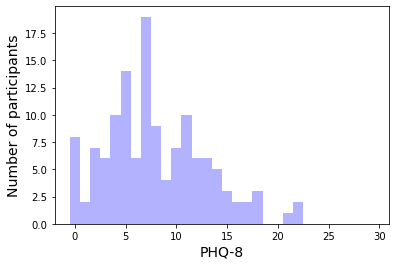

In [20]:
plt.hist(participant_df['phq8'], bins=np.arange(-.5,30.5), alpha=.3, color='b', label='phq8 at entry')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('PHQ-8', fontsize=14)
plt.show()

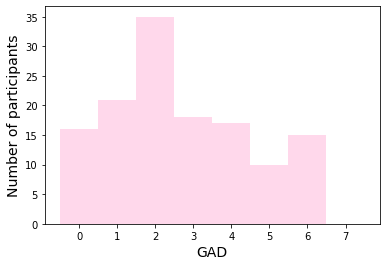

In [21]:
plt.hist(participant_df['gad'], bins=np.arange(-.5,8.5), alpha=.3, color='xkcd:pink', label='gad at entry')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('GAD', fontsize=14)
plt.show()

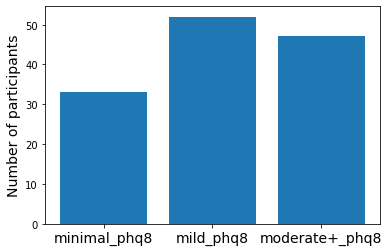

In [22]:
temp = participant_df[['minimal_phq8', 'mild_phq8', 'moderate+_phq8']].sum()

plt.bar(np.arange(temp.shape[0]), temp.values)
plt.xticks(np.arange(temp.shape[0]), temp.index, fontsize=14)
plt.ylabel('Number of participants', fontsize=14)
plt.show()

## How did mood score before chat relate to phq8?

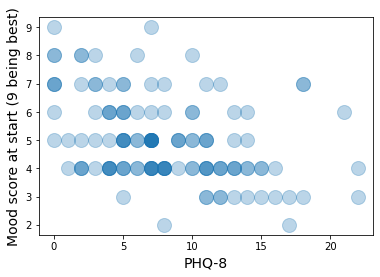

In [23]:
plt.plot(participant_df['phq8'], participant_df['mood_before'], 'o', alpha=.3, markersize=14)
plt.ylabel('Mood score at start (9 being best)', fontsize=14)
plt.xlabel('PHQ-8', fontsize=14)
plt.show()

## Did chatting with the bot provide any relief?

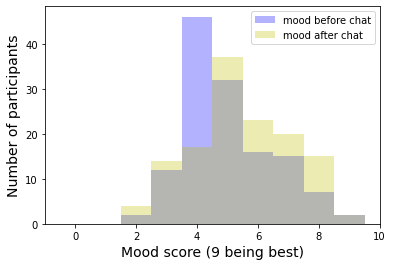

In [24]:

plt.hist(participant_df['mood_before'], bins=np.arange(-.5,10.5), alpha=.3, color='b', label='mood before chat')
plt.hist(participant_df['mood_after'], bins=np.arange(-.5,10.5), alpha=.3, color='y', label='mood after chat')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Mood score (9 being best)', fontsize=14)
plt.legend()
plt.show()



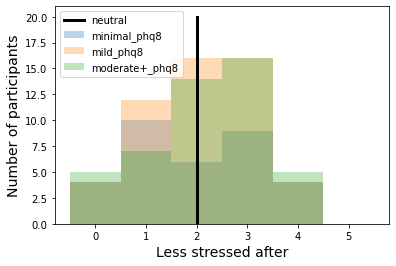

In [25]:
for i, phq8_bucket in enumerate(phq8_buckets):
    plt.hist(phq8_dfs[phq8_bucket]['less_stressed_after'], bins=np.arange(-.5, 6.5), label=phq8_bucket, alpha=.3)

plt.plot([2,2], [0,20], 'k', linewidth=3, label='neutral')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Less stressed after', fontsize=14)
plt.legend()
plt.show()

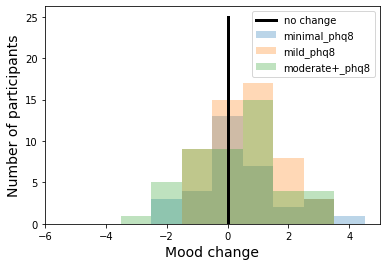

In [26]:
for i, phq8_bucket in enumerate(phq8_buckets):
    plt.hist(phq8_dfs[phq8_bucket]['mood_change'], bins=np.arange(-5.5,5.5), label=phq8_bucket, alpha=.3)
plt.plot([0,0], [0,25], 'k', linewidth=3, label='no change')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Mood change', fontsize=14)
plt.legend()
plt.show()

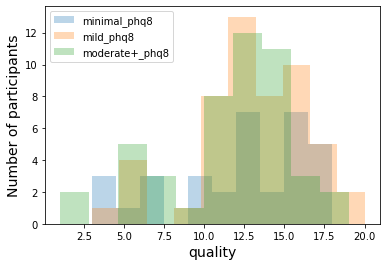

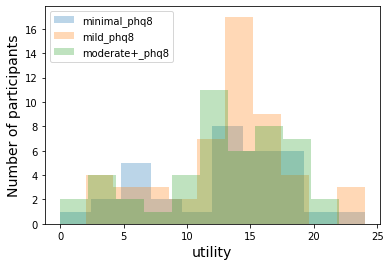

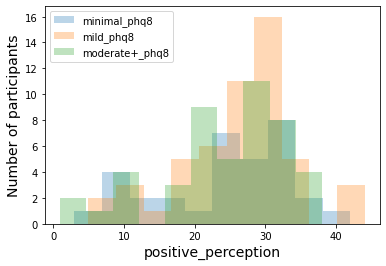

In [27]:
for measure in ['quality', 'utility', 'positive_perception']:
    for i, phq8_bucket in enumerate(phq8_buckets):
        plt.hist(phq8_dfs[phq8_bucket][measure], label=phq8_bucket, alpha=.3)
    plt.ylabel('Number of participants', fontsize=14)
    plt.xlabel(measure, fontsize=14)
    plt.legend()
    plt.show()

### Were depressed people more likely to feel better/worse after chatting with bot?

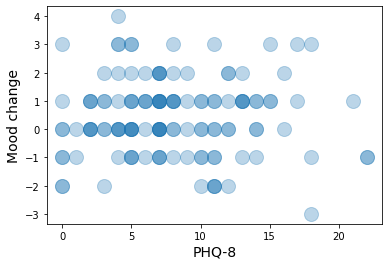

In [28]:
plt.plot(participant_df['phq8'], participant_df['mood_change'], 'o', alpha=.3, markersize=14)
plt.ylabel('Mood change', fontsize=14)
plt.xlabel('PHQ-8', fontsize=14)
plt.show()

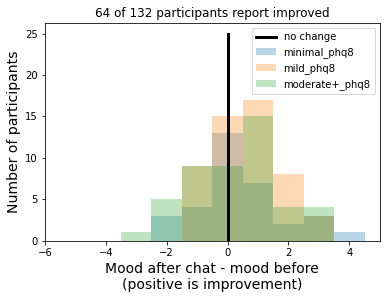

In [29]:
for phq8_bucket in phq8_buckets:
    ind = participant_df[phq8_bucket]
    plt.hist(participant_df['mood_change'][ind], bins=np.arange(-5.5,5.5), label=phq8_bucket, alpha=.3)
    
plt.plot([0,0], [0,25], 'k', linewidth=3, label='no change')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Mood after chat - mood before\n(positive is improvement)', fontsize=14)
plt.title('%s of %s participants report improved' % (sum(participant_df['mood_change']>0), participant_df.shape[0]))
plt.legend(loc='best')
plt.show()


## Is change in mood related to PHQ8? ***

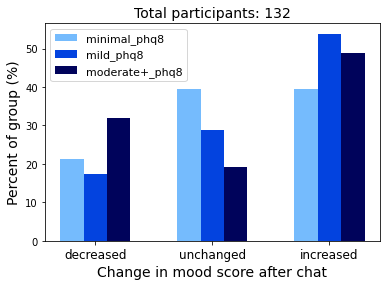

In [30]:

for i, phq8_bucket in enumerate(phq8_buckets):
    df = phq8_dfs[phq8_bucket]
    improved = np.mean(df['mood_improved'])
    unchanged = np.mean(df['mood_unchanged'])
    worsened = np.mean(df['mood_worsened'])

    temp = [worsened, unchanged, improved]
    plt.bar(np.arange(len(temp)) + (i-1)*.2, 100*np.array(temp), width=.2, color=phq8_colors[i], label=phq8_bucket)
    
temp_ticks = ['decreased', 'unchanged', 'increased']
plt.xticks(range(len(temp)), temp_ticks, fontsize=12)
plt.ylabel('Percent of group (%)', fontsize=14)
plt.xlabel('Change in mood score after chat', fontsize=14)
plt.title('Total participants: %s' % participant_df.shape[0], fontsize=14)
plt.legend(fontsize=11)
plt.show()

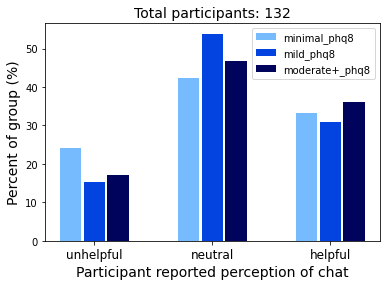

In [31]:
for i, phq8_bucket in enumerate(phq8_buckets):
    df = phq8_dfs[phq8_bucket]
    helpful = np.mean(16 <= df['utility'])
    neutral = np.mean((8 <= df['utility']) & (df['utility'] < 16))
    unhelpful = np.mean(df['utility'] < 8)

    temp = [unhelpful, neutral, helpful]
    plt.bar(np.arange(len(temp)) + (i-1)*.2, 100*np.array(temp), width=.18, color=phq8_colors[i], label=phq8_bucket)
    
temp_ticks = ['unhelpful', 'neutral', 'helpful']
plt.xticks(range(len(temp)), temp_ticks, fontsize=12)
plt.ylabel('Percent of group (%)', fontsize=14)
plt.xlabel('Participant reported perception of chat', fontsize=14)
plt.title('Total participants: %s' % participant_df.shape[0], fontsize=14)
plt.legend()
plt.show()

### Was change in mood related to mood at start?

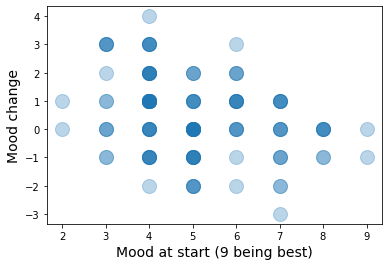

In [32]:
plt.plot(participant_df['mood_before'], participant_df['mood_change'], 'o', alpha=.3, markersize=14)
# plt.plot([0, 9],[0, 0], 'k', linewidth=3, label='no change')
plt.ylabel('Mood change', fontsize=14)
plt.xlabel('Mood at start (9 being best)', fontsize=14)
# plt.legend()
plt.show()

### Was utility related to mood at start?

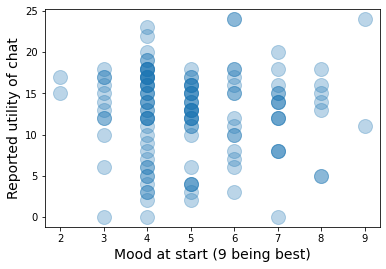

In [33]:
plt.plot(participant_df['mood_before'], participant_df['utility'], 'o', alpha=.3, markersize=14)
plt.ylabel('Reported utility of chat', fontsize=14)
plt.xlabel('Mood at start (9 being best)', fontsize=14)
plt.show()

### Was utility related to latent depression?

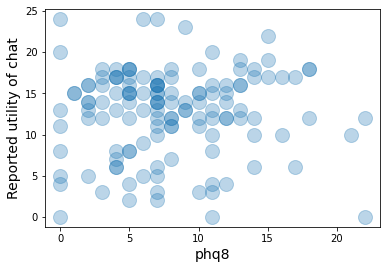

In [34]:
plt.plot(participant_df['phq8'], participant_df['utility'], 'o', alpha=.3, markersize=14)
plt.ylabel('Reported utility of chat', fontsize=14)
plt.xlabel('phq8', fontsize=14)
plt.show()

## Do people who are more familiar with chatbots experience more relief/benefit?

* Q242: Have you ever chatted with a chatbot? ['Yes' 'No' "I don't know" nan] 'chatbot_experience'
* Q251: Have you ever used a chatbot for mental health? ['Yes' 'No' "I don't know" nan] 'chatbot_mh_experience'
* Q219: how hard to imagine mood? ['Yes' 'No' "I don't know" nan] 'cant_imagine_mood'

In [35]:
print('Used chatbot for mental health: ', sum(participant_df['chatbot_mh_experience']))
print('Cannot imagine a bad mood: ', sum(participant_df['cant_imagine_mood']))

Used chatbot for mental health:  6
Cannot imagine a bad mood:  2


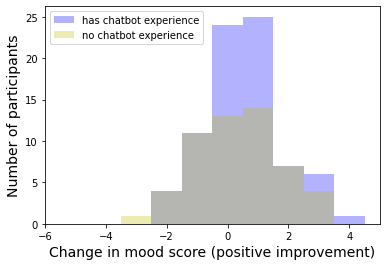

In [36]:
ind = participant_df['chatbot_experience'] 
plt.hist(participant_df[ind]['mood_change'], bins=np.arange(-5.5,5.5), alpha=.3, color='b', label='has chatbot experience')
plt.hist(participant_df[~ind]['mood_change'], bins=np.arange(-5.5,5.5), alpha=.3, color='y', label='no chatbot experience')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Change in mood score (positive improvement)', fontsize=14)
plt.legend()
plt.show()

## Did depressed participants engage/more less? (average message length overall)

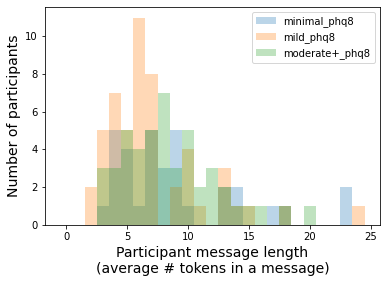

In [37]:

for i, phq8_bucket in enumerate(phq8_buckets):
    df = phq8_dfs[phq8_bucket]
    plt.hist(df['avg_message_tok'], bins=np.arange(-.5, 25.5), alpha=.3, label=phq8_bucket)
    
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Participant message length\n(average # tokens in a message)', fontsize=14)
plt.legend()
plt.show()

### Did messages decrease in length later in the conversation?

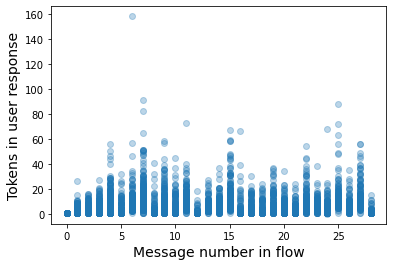

In [38]:
plt.plot(message_df['Flow Index'].values, message_df['user_message_len'].values, 'o', alpha =.3)

plt.ylabel('Tokens in user response', fontsize=14)
plt.xlabel('Message number in flow', fontsize=14)
plt.show()

## Annotation overview

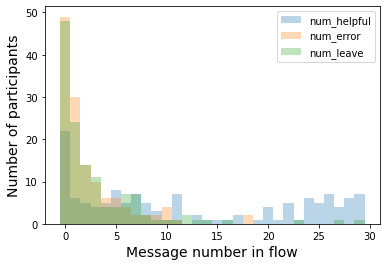

In [39]:
for col in ['num_helpful', 'num_error', 'num_leave']:
    plt.hist(participant_df[col], bins=np.arange(-.5,30.5), alpha=.3, label=col)

plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Message number in flow', fontsize=14)
plt.legend()
plt.show()

## When did people first want to leave the conversation

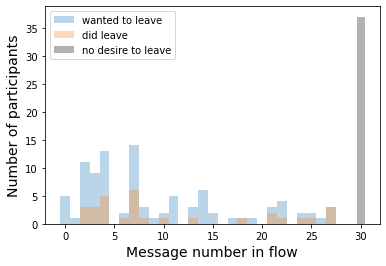

In [40]:
plt.hist(participant_df['first_leave'], bins=np.arange(-.5,30.5), alpha=.3, label='wanted to leave')
plt.hist(participant_df[participant_df['stopped_early']]['first_leave'], bins=np.arange(-.5,30.5), alpha=.3, label='did leave')

# completed conversation
plt.bar([30], [np.isnan(participant_df['first_leave'].values).sum()], alpha=.3, color='k', label='no desire to leave')

plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Message number in flow', fontsize=14)
plt.legend()
plt.show()

## Would participants who experienced benefit have left early?

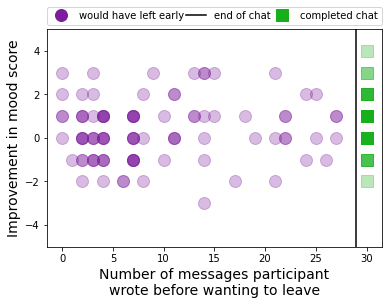

In [43]:
ind = participant_df['left_after'] < FLOW_LEN

plt.plot(participant_df[ind]['left_after'], participant_df[ind]['mood_change'], 'o', color='xkcd:purple', markersize=12,alpha=.3)

plt.plot(30*np.ones(sum(~ind)), participant_df[~ind]['mood_change'], 's', color='xkcd:green', markersize=12, alpha=.3)
plt.plot([FLOW_LEN, FLOW_LEN], [-5, 5], '-k')

plt.plot(np.NaN, 'o', color='xkcd:purple', markersize=12, label='would have left early')
plt.plot(np.NaN, '-k', markersize=12, label='end of chat')
plt.plot(np.NaN, 's', color='xkcd:green', markersize=12, label='completed chat')

plt.ylabel('Improvement in mood score', fontsize=14)
plt.xlabel('Number of messages participant\nwrote before wanting to leave', fontsize=14)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), mode="expand", borderaxespad=0, loc='lower left', ncol=3)
plt.ylim([-5, 5])
plt.show()

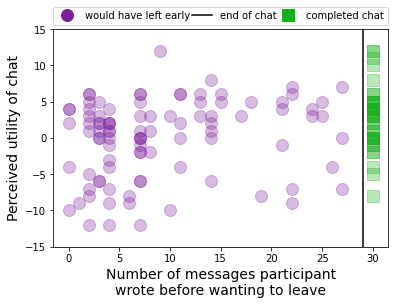

In [44]:
ind = participant_df['left_after'] < FLOW_LEN

plt.plot(participant_df[ind]['left_after'], participant_df[ind]['centered_utility'], 'o', color='xkcd:purple', markersize=12,alpha=.3)

plt.plot(30*np.ones(sum(~ind)), participant_df[~ind]['centered_utility'], 's', color='xkcd:green', markersize=12, alpha=.3)
plt.plot([FLOW_LEN, FLOW_LEN], [-15, 15], '-k')

plt.plot(np.NaN, 'o', color='xkcd:purple', markersize=12, label='would have left early')
plt.plot(np.NaN, '-k', markersize=12, label='end of chat')
plt.plot(np.NaN, 's', color='xkcd:green', markersize=12, label='completed chat')


plt.ylabel('Perceived utility of chat', fontsize=14)
plt.xlabel('Number of messages participant\nwrote before wanting to leave', fontsize=14)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), mode="expand", borderaxespad=0, loc='lower left', ncol=3)
plt.ylim([-15, 15])
plt.show()

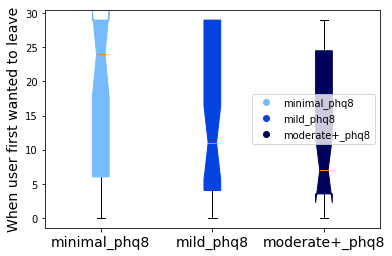

In [49]:
for i, phq8_bucket in enumerate(phq8_buckets):
    c = phq8_colors[i]
    df = phq8_dfs[phq8_bucket]
    plt.boxplot(df['left_after'], positions = [i], showfliers=False, notch=True, patch_artist=True, boxprops=dict(facecolor=c, color=c))
    plt.plot(np.NaN, 'o', color=c, label=phq8_bucket)
        
plt.ylabel('When user first wanted to leave', fontsize=14)
# plt.xlabel('Strategy', fontsize=14)
plt.xticks(np.arange(len(phq8_buckets)), phq8_buckets, fontsize=14)
plt.legend()
plt.show()


In [50]:
a = sum(participant_df['first_leave'] <= 5)
b = participant_df.shape[0]
c = sum(np.isnan(participant_df['first_leave']))
print('Leave within first 5 messages: %s of %s (%.2f%%)' % (a, b, 100.*float(a)/b))
print('Never leave: %s of %s (%.2f%%)' % (c, b, 100.*float(c)/b))

Leave within first 5 messages: 39 of 132 (29.55%)
Never leave: 37 of 132 (28.03%)


## How long after the first error did individuals want to leave?

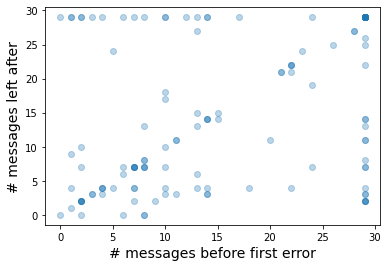

In [51]:
# plt.plot(participant_df['first_error'], participant_df['first_leave'], 'o', alpha=.3)
plt.plot(participant_df['num_before_error'], participant_df['left_after'], 'o', alpha=.3)
plt.ylabel('# messages left after', fontsize=14)
plt.xlabel('# messages before first error', fontsize=14)
plt.show()

## What is the first reason to leave?

### For people who had un/improved mood?
* people with improved mood were most likely to have completed the conversation
* people with worsened mood were most likely to have wanted to leave because they felt the bot was not listening
* A small percent of people from each group left early without justification, i.e., annotating why they wanted to leave

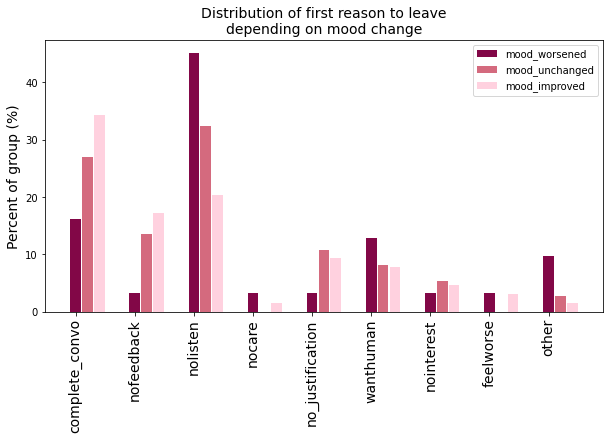

In [52]:


fig, ax = plt.subplots(figsize=(10,5))

reasons = [x[0] for x in Counter(participant_df['why_first_leave']).items()]

for i, outcome in enumerate(['mood_worsened', 'mood_unchanged', 'mood_improved']):
    c = Counter(participant_df[participant_df[outcome]]['why_first_leave'])
    counts = [c[x] for x in reasons]
    plt.bar(np.arange(len(reasons))+i*.2, counts/np.sum(counts)*100., width=.18, color=mood_change_colors[i], label=outcome)
    
plt.xticks(range(len(reasons)), reasons, fontsize=14, rotation=90)
plt.ylabel('Percent of group (%)', fontsize=14)
plt.title('Distribution of first reason to leave\ndepending on mood change', fontsize=14)
plt.legend()
plt.show()

### For people who started with low/high phq8
* People with minimal phq8 were more likely to complete the conversation without indicating a desire to leave early
* Feeling that the bot was not listeing was the primarily indicated reason for wanting to leave early, followed by no feedback
* While the desire for human connection was not the primarily indicated issue, it was higher with higher phq8
* Again, a small percent of people from each group left early without justification, i.e., annotating why they wanted to leave

**NOTE**: "bot isn't listening to me" was listed first in dropdown, followed by "bot doesn't give feedback". Thus, it's hard to know if these effects are just a consequence of study design.

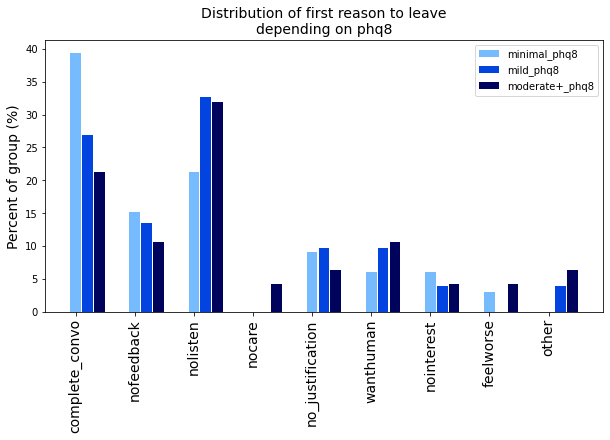

In [53]:
fig, ax = plt.subplots(figsize=(10,5))

reasons = [x[0] for x in Counter(participant_df['why_first_leave']).items()]

for i, phq8_bucket in enumerate(phq8_buckets):
    c = Counter(phq8_dfs[phq8_bucket]['why_first_leave'])
    counts = [c[x] for x in reasons]
    plt.bar(np.arange(len(reasons))+i*.2, counts/np.sum(counts)*100., width=.18, color=phq8_colors[i], label=phq8_bucket)
    
plt.xticks(range(len(reasons)), reasons, fontsize=14, rotation=90)
plt.ylabel('Percent of group (%)', fontsize=14)
plt.title('Distribution of first reason to leave\ndepending on phq8', fontsize=14)
plt.legend()
plt.show()


### Frequency of reason for wanting to leave throughout

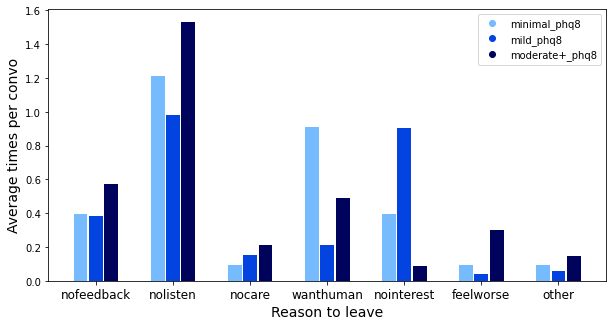

In [54]:
reasons_to_leave = ['nofeedback',
 'nolisten',
 'nocare',
 'wanthuman',
 'nointerest',
 'feelworse',
 'other']

def temp_func(df, labelname, color, offset=0):
    num_convo = float(df['sona'].unique().shape[0])
    c = Counter(df[df['leave_bool']]['why_leave'].values)
    for r, reason in enumerate(reasons_to_leave):
        plt.bar(r+offset, c[reason] / num_convo, color=color, width=.18)
    plt.plot(np.NaN, 'o', color=color, label=labelname)
    

plt.subplots(figsize=(10,5)) 
for i, phq8_bucket in enumerate(phq8_buckets):
    temp_func(message_df.merge(phq8_dfs[phq8_bucket][['sona']].astype(int), on='sona', how='right'), phq8_bucket, phq8_colors[i], offset=i*.2)


plt.ylabel('Average times per convo', fontsize=14)
plt.xlabel('Reason to leave', fontsize=14)
plt.xticks(np.arange(len(reasons_to_leave))+.2, reasons_to_leave, fontsize=12)
plt.legend()
plt.show()

## Do people who write more report mood improvement or utility?

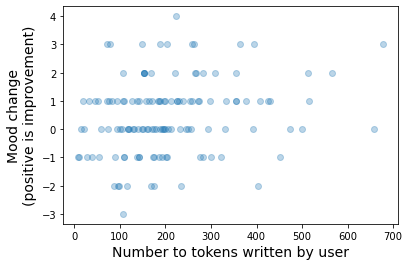

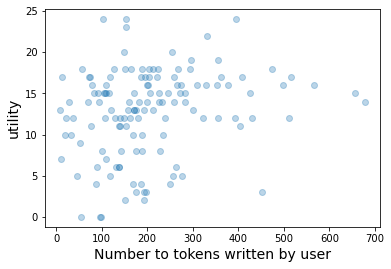

In [55]:
plt.plot(participant_df['tot_message_tok'], participant_df['mood_change'], 'o', alpha=.3)
plt.ylabel('Mood change\n(positive is improvement)', fontsize=14)
plt.xlabel('Number to tokens written by user', fontsize=14)
plt.show()


plt.plot(participant_df['tot_message_tok'], participant_df['utility'], 'o', alpha=.3)
plt.ylabel('utility', fontsize=14)
plt.xlabel('Number to tokens written by user', fontsize=14)
plt.show()

### Does bot performance relate to efficacy/relief?

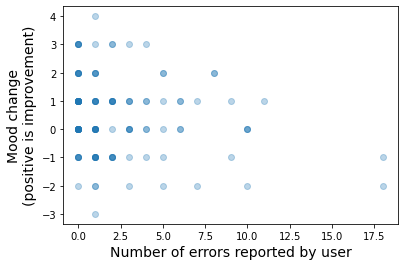

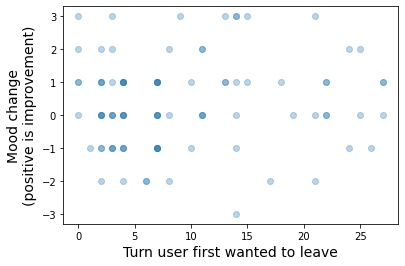

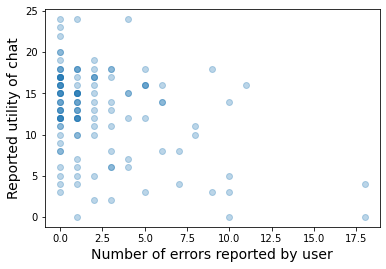

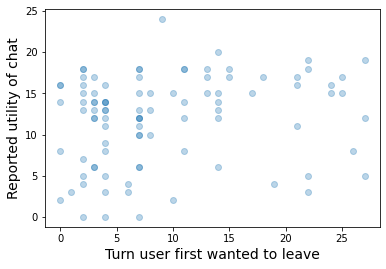

In [56]:
plt.plot(participant_df['num_error'], participant_df['mood_change'], 'o', alpha=.3)
plt.ylabel('Mood change\n(positive is improvement)', fontsize=14)
plt.xlabel('Number of errors reported by user', fontsize=14)
plt.show()



plt.plot(participant_df['first_leave'], participant_df['mood_change'], 'o', alpha=.3)
plt.ylabel('Mood change\n(positive is improvement)', fontsize=14)
plt.xlabel('Turn user first wanted to leave', fontsize=14)
plt.show()



plt.plot(participant_df['num_error'], participant_df['utility'], 'o', alpha=.3)
plt.ylabel('Reported utility of chat', fontsize=14)
plt.xlabel('Number of errors reported by user', fontsize=14)
plt.show()


plt.plot(participant_df['first_leave'], participant_df['utility'], 'o', alpha=.3)
plt.ylabel('Reported utility of chat', fontsize=14)
plt.xlabel('Turn user first wanted to leave', fontsize=14)
plt.show()


# 'positive_perception'
# 'concern'
# 'open_to_bot'

# Message level plots

In [57]:
print('Message_df dimension: ', message_df.shape)
message_df[:3]

Message_df dimension:  (3433, 16)


,Unnamed: 0,Flow Index,User Message,Bot Response,helpful,error,why_leave,helpful_bool,error_bool,leave_bool,first_leave,first_error,user_message_len,sona,cid,strategy
0,0,0,START,"Hi, it’s great to meet you!",NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,neutral
1,1,1,thanks,How are you doing?,NaN,NaN,na,False,False,False,False,False,1,50375,50375_82125de0,chitchat
2,2,2,im okay,I've heard that many people stay at home more ...,NaN,NaN,na,False,False,False,False,False,3,50375,50375_82125de0,chitchat


In [58]:
turn_df = message_df.groupby('Flow Index').agg(np.sum)
turn_df[:3]

,Unnamed: 0,helpful,error,helpful_bool,error_bool,leave_bool,first_leave,first_error,user_message_len,sona
Flow Index,,,,,,,,,,
0,0,60.0,2.0,60,2,5,5,2,132,6193430
1,132,59.0,6.0,59,6,3,1,5,451,6193430
2,264,61.0,12.0,61,12,13,11,10,702,6193430


### When was the conversation helpful/error

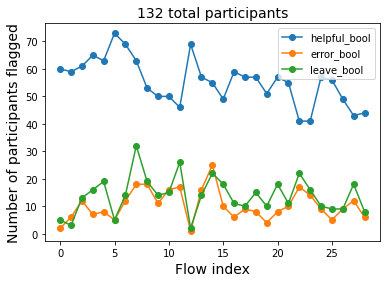

In [59]:
xs = np.arange(turn_df.shape[0])

for i, col in enumerate(['helpful_bool', 'error_bool', 'leave_bool']):
    plt.plot(xs, turn_df[col].values, 'o-', label=col)
    
plt.ylabel('Number of participants flagged', fontsize=14)
plt.xlabel('Flow index', fontsize=14)
plt.title('%s total participants' % participant_df.shape[0], fontsize=14)
plt.legend()
plt.show()

In [62]:
for i in [4, 5, 7, 12, 25]:
    print('Message %s text: \n%s\n' % (i, flow_df.loc[i, 'flow_fixed']))

Message 4 text: 
Ok. These last few months have been really difficult, and there's a lot going on in the world right now. Have you been feeling more negative emotions lately?

Message 5 text: 
I understand. What’s been the hardest part for you? 

Message 7 text: 
Thanks for sharing. Many people have felt more sad, lonely, or stressed lately, and that's ok, but it can make each day harder than usual.

Message 12 text: 
What would it take for your day to improve by just 1 point?

Message 25 text: 
I see. Sometimes it's nice to think about things that we are looking forward to. What do you most look forward to doing once the pandemic is over?  



### Errors correlate with wanting to leave

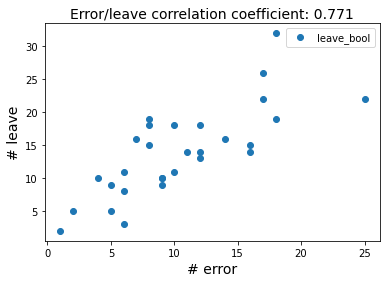

In [63]:
temp = np.corrcoef(turn_df[['error_bool', 'leave_bool']].values, rowvar=False) # Rowvar false sets columns to variable


plt.plot(turn_df['error_bool'].values, turn_df['leave_bool'].values, 'o', label=col)
plt.ylabel('# leave', fontsize=14)
plt.xlabel('# error', fontsize=14)
plt.title('Error/leave correlation coefficient: %.3f' % temp[0,1], fontsize=14)
plt.legend()
plt.show()

### What types of messages were most helpful to participants (depressed/not)

Check the strategy ordering matches!
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']


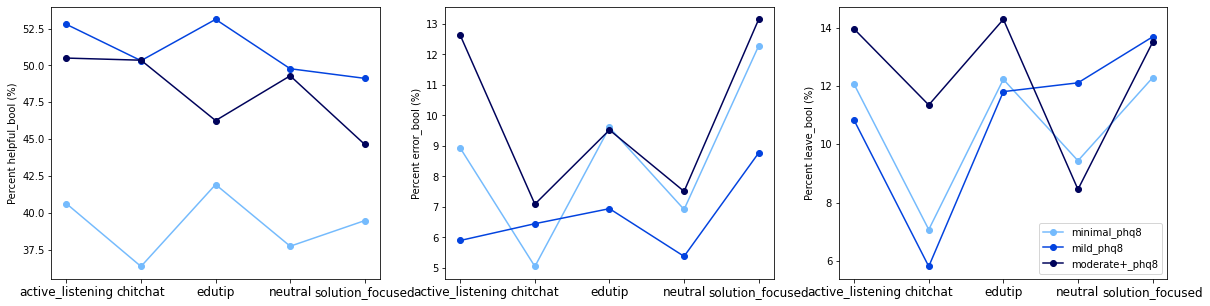

In [64]:
def temp_func(ax, df, labelname, color):
    type_df = df.groupby('strategy').agg(np.mean)
    
    xs = np.arange(type_df.shape[0])
    print(type_df.index.values)

    for i, col in enumerate(['helpful_bool', 'error_bool', 'leave_bool']):
        ax[i].plot(xs, 100.0 * type_df[col].values, 'o-', color=color, label=labelname)
        ax[i].set_ylabel('Percent %s (%%)' % col)
        ax[i].set_xticks(xs)
        ax[i].set_xticklabels(type_df.index.values, fontsize=12)
#         ax[i].set_ylim([0,100])
        
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

print('Check the strategy ordering matches!')

for i, phq8_bucket in enumerate(phq8_buckets):
    temp_func(ax, message_df.merge(phq8_dfs[phq8_bucket][['sona']], on='sona', how='right'), phq8_bucket, phq8_colors[i])


    
# plt.ylabel('Fraction participants flagged', fontsize=14)
# plt.xlabel('Strategy', fontsize=14)
# plt.title('%s total participants' % participant_df.shape[0], fontsize=14)
# plt.xticks(xs, type_df.index.values)
plt.legend()
plt.show()

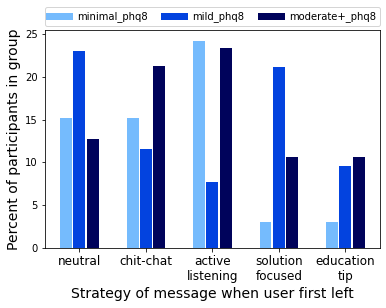

In [65]:
strategy_names = {'neutral': 'neutral', 
                  'chitchat': 'chit-chat', 
                  'active_listening': 'active\nlistening', 
                  'solution_focused': 'solution\nfocused',
                  'edutip': 'education\ntip'}


def temp_func(ax, df, labelname, strategies, color, offset):
    c = Counter(df[df['first_leave']]['strategy'])
    num_convo = len(df['sona'].unique())
    num_left_early = df[df['first_leave']]['strategy'].shape[0]
    
    xs = np.arange(strategies.shape[0])
    
    for s, strategy in enumerate(strategies):
#         ax[1].bar(s+offset, c[strategy], color=color, width=.18)
        ax.bar(s+offset, 100.0 * c[strategy] / num_convo, color=color, width=.18)
#     ax[1].set_ylabel('Count')    
    ax.set_ylabel('Percent of participants in group', fontsize=14)
    ax.set_xlabel('Strategy of message when user first left', fontsize=14)
    ax.plot(np.NaN, color=color, label=labelname, linewidth=7)
    
    ax.set_xticks(xs)
    ax.set_xticklabels([strategy_names[s] for s in strategies], fontsize=12)
        

fig, ax = plt.subplots()#1,2, figsize=(13,5))
strategies = message_df['strategy'].unique()

for i, phq8_bucket in enumerate(phq8_buckets):
    temp_func(ax, message_df.merge(phq8_dfs[phq8_bucket][['sona']], on='sona', how='right'), phq8_bucket, strategies, phq8_colors[i], offset=(i-1)*.2)


plt.legend(bbox_to_anchor=(0,1.02,1,0.2), mode="expand", borderaxespad=0, loc='lower left', ncol=3)
# plt.legend()
plt.show()

Check the strategy ordering matches!
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']
['active_listening' 'chitchat' 'edutip' 'neutral' 'solution_focused']


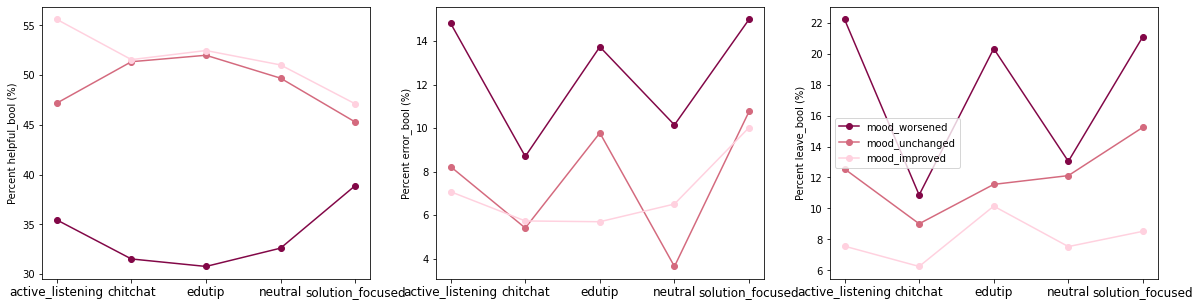

In [66]:
def temp_func(ax, df, labelname, color):
    type_df = df.groupby('strategy').agg(np.mean)
    
    xs = np.arange(type_df.shape[0])
    print(type_df.index.values)

    for i, col in enumerate(['helpful_bool', 'error_bool', 'leave_bool']):
        ax[i].plot(xs, 100.0 * type_df[col].values, 'o-', color=color, label=labelname)
        ax[i].set_ylabel('Percent %s (%%)' % col)
        ax[i].set_xticks(xs)
        ax[i].set_xticklabels(type_df.index.values, fontsize=12)
#         ax[i].set_ylim([0,100])
        
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

print('Check the strategy ordering matches!')

for i, mood_bucket in enumerate(['mood_worsened', 'mood_unchanged', 'mood_improved']):
    df = participant_df[participant_df[mood_bucket]][['sona']].astype(int)
    temp_func(ax, message_df.merge(df, on='sona', how='right'), mood_bucket, mood_change_colors[i])


    
# plt.ylabel('Fraction participants flagged', fontsize=14)
# plt.xlabel('Strategy', fontsize=14)
# plt.title('%s total participants' % participant_df.shape[0], fontsize=14)
# plt.xticks(xs, type_df.index.values)
plt.legend()
plt.show()

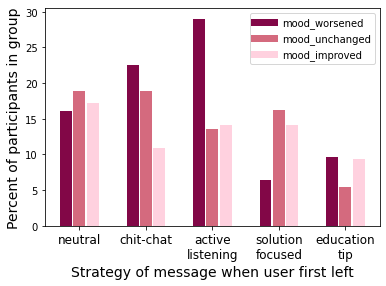

In [67]:
strategy_names = {'neutral': 'neutral', 
                  'chitchat': 'chit-chat', 
                  'active_listening': 'active\nlistening', 
                  'solution_focused': 'solution\nfocused',
                  'edutip': 'education\ntip'}


def temp_func(ax, df, labelname, strategies, color, offset):
    c = Counter(df[df['first_leave']]['strategy'])
    num_convo = len(df['sona'].unique())
    num_left_early = df[df['first_leave']]['strategy'].shape[0]
    
    xs = np.arange(strategies.shape[0])
    
    for s, strategy in enumerate(strategies):
#         ax[1].bar(s+offset, c[strategy], color=color, width=.18)
        ax.bar(s+offset, 100.0 * c[strategy] / num_convo, color=color, width=.18)
#     ax[1].set_ylabel('Count')    
    ax.set_ylabel('Percent of participants in group', fontsize=14)
    ax.set_xlabel('Strategy of message when user first left', fontsize=14)
    ax.plot(np.NaN, color=color, label=labelname, linewidth=7)
    
    ax.set_xticks(xs)
    ax.set_xticklabels([strategy_names[s] for s in strategies], fontsize=12)
        

fig, ax = plt.subplots()#1,2, figsize=(13,5))
strategies = message_df['strategy'].unique()


for i, mood_bucket in enumerate(['mood_worsened', 'mood_unchanged', 'mood_improved']):
    df = participant_df[participant_df[mood_bucket]][['sona']]#.astype(int)
    temp_func(ax, message_df.merge(df, on='sona', how='right'), mood_bucket, strategies, mood_change_colors[i], offset=(i-1)*.2)



# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), mode="expand", borderaxespad=0, loc='lower left', ncol=3)
plt.legend()
plt.show()

## Engagement

### Engagement over the course of the conversation?

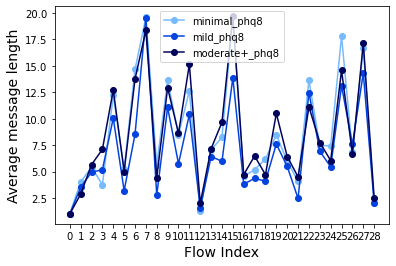

In [68]:
def temp_func(df, labelname, color):
    temp = df.groupby('Flow Index').agg(np.mean)
    ys = temp['user_message_len']
    xs = np.arange(temp.shape[0])
    plt.plot(xs, ys, 'o-', color=color, label=labelname)
    return xs, temp.index.values

for i, phq8_bucket in enumerate(phq8_buckets):
    xs, ticklabels = temp_func(message_df.merge(phq8_dfs[phq8_bucket][['sona']].astype(int), on='sona', how='right'), phq8_bucket, phq8_colors[i])
    
plt.ylabel('Average message length', fontsize=14)
plt.xlabel('Flow Index', fontsize=14)
plt.xticks(xs, ticklabels)
plt.legend()
plt.show()

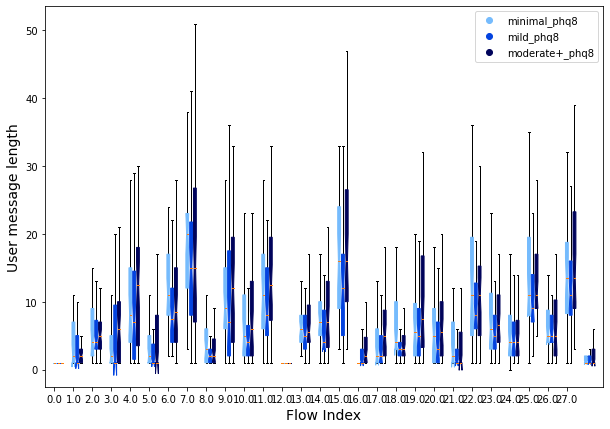

In [69]:
def temp_func(df, labelname, offset=0, color='b'):
    c = color
    for i in df['Flow Index'].unique():
        vals = df[df['Flow Index'] == i]['user_message_len'].values
        plt.boxplot(vals, positions = [i+offset], showfliers=False, notch=True, patch_artist=True, boxprops=dict(facecolor=c, color=c))
    plt.plot(np.NaN, 'o', color=c, label=labelname)
        
plt.subplots(figsize=(10,7))
for i, phq8_bucket in enumerate(phq8_buckets):
    temp_func(message_df.merge(phq8_dfs[phq8_bucket][['sona']].astype(int), on='sona', how='right'), phq8_bucket, offset=.2*i, color=phq8_colors[i])
    
    
plt.ylabel('User message length', fontsize=14)
plt.xlabel('Flow Index', fontsize=14)
plt.xticks(np.arange(28))
plt.legend()
plt.show()

### Engagement by message type

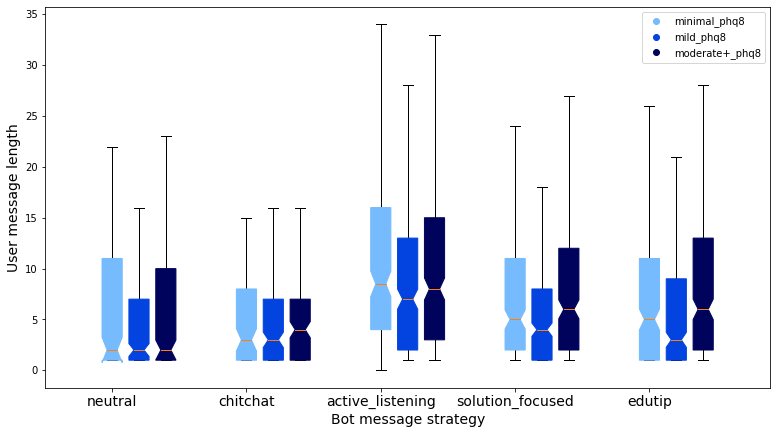

In [70]:
def temp_func(df, labelname, offset=0, color='b'):
    c = color
    strategies = df['strategy'].unique()
    for i, s in enumerate(strategies):
        vals = df[df['strategy'] == s]['user_message_len'].values
        plt.boxplot(vals, positions = [i+offset], showfliers=False, notch=True, patch_artist=True, boxprops=dict(facecolor=c, color=c))
    plt.plot(np.NaN, 'o', color=c, label=labelname)
        
plt.subplots(figsize=(13,7))
for i, phq8_bucket in enumerate(phq8_buckets):
    temp_func(message_df.merge(phq8_dfs[phq8_bucket][['sona']].astype(int), on='sona', how='right'), phq8_bucket, color=phq8_colors[i], offset=i*.2)

    
plt.ylabel('User message length', fontsize=14)
plt.xlabel('Bot message strategy', fontsize=14)
strategies = message_df['strategy'].unique()
plt.xticks(np.arange(len(strategies)), strategies, fontsize=14)
plt.legend()
plt.show()


# Models!

In [71]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [72]:
print(Counter(participant_df['gender'].values), '\n')
print(Counter(participant_df['why_first_leave'].values), '\n')


Counter({'Female': 107, 'Male': 23, 'Transgender': 1, 'Other or not listed; please specify': 1}) 

Counter({'nolisten': 39, 'complete_convo': 37, 'nofeedback': 17, 'wanthuman': 12, 'no_justification': 11, 'nointerest': 6, 'other': 5, 'feelworse': 3, 'nocare': 2}) 



In [171]:
# participant_df['Female'] = participant_df['gender'] == 'Female'
# participant_df['Age'] = participant_df['age'].astype(float)

# participant_df['feel_bad'] = participant_df['phq8'] + participant_df['gad']

# 'nofeedback', 'wanthuman', 'no_justification', 
other_reasons = ['nointerest', 'other', 'feelworse', 'nocare']
for i in participant_df.index:
    x = participant_df.loc[i, 'why_first_leave']
    participant_df.loc[i, 'why_first_leave_condensed'] = 'other' if x in other_reasons else x


print(Counter(participant_df['why_first_leave_condensed'].values))

Counter({'nolisten': 39, 'complete_convo': 37, 'nofeedback': 17, 'other': 16, 'wanthuman': 12, 'no_justification': 11})


In [74]:
participant_df['chatbot_experience'].mean()

0.5909090909090909

## Does perception of helpfulness relate to errors controlling for other factors?

I think this isn't the best dependent composite variable to model. It is utility + quality and we don't ultimately care about quality. Also, obviously the quality will be perceived to be better if there are fewer errors. Let's consider the utility measure (below) instead.

In [ ]:
# res = smf.ols("positive_perception ~ C(Female) + num_helpful + C(why_first_leave) \
#                 + left_after + avg_message_tok + mood_before + phq8 * num_error + open_to_bot \
#               + num_before_error", data=participant_df).fit()
# print(res.summary())

## Does perceived efficacy (utility) relate to errors controlling for other features?

In [368]:
res = smf.ols("centered_utility ~ C(Female) + Age + num_helpful + C(why_first_leave_condensed) \
                + left_after + np.log(avg_message_tok) + mood_before + feel_bad * num_error + chatbot_experience\
              ", data=participant_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       centered_utility   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     4.890
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           2.67e-07
Time:                        15:05:53   Log-Likelihood:                -373.44
No. Observations:                 132   AIC:                             778.9
Df Residuals:                     116   BIC:                             825.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

### Check that qq plot looks good

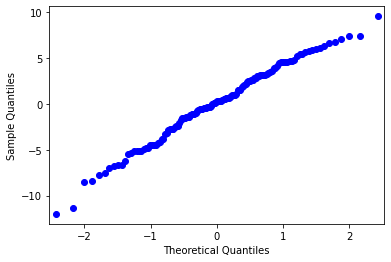

In [364]:
sm.qqplot(res.resid)
plt.show()

In [76]:
print('Covariate corrlation matrix:')
print(np.round(np.corrcoef(participant_df[['num_helpful','left_after','num_before_error','avg_message_tok',
                                           'mood_before','open_to_bot','phq8','num_error']].values, rowvar=False), 2))


Covariate corrlation matrix:
[[ 1.    0.23 -0.01 -0.14 -0.    0.04 -0.01  0.17]
 [ 0.23  1.    0.38 -0.04  0.05  0.14 -0.15 -0.2 ]
 [-0.01  0.38  1.    0.06 -0.    0.17 -0.19 -0.59]
 [-0.14 -0.04  0.06  1.   -0.06  0.11 -0.04 -0.03]
 [-0.    0.05 -0.   -0.06  1.    0.1  -0.4   0.08]
 [ 0.04  0.14  0.17  0.11  0.1   1.   -0.07 -0.2 ]
 [-0.01 -0.15 -0.19 -0.04 -0.4  -0.07  1.   -0.02]
 [ 0.17 -0.2  -0.59 -0.03  0.08 -0.2  -0.02  1.  ]]


In [77]:
print('Correlation coefficient with first error and total number: ')
print(np.round(np.corrcoef(participant_df[['num_before_error','num_error']].values, rowvar=False), 2))

Correlation coefficient with first error and total number: 
[[ 1.   -0.59]
 [-0.59  1.  ]]


## Does observed efficacy (i.e., mood change) relate to errors controlling for other factors?

* Mood change is noisy and thus it's unsurprising that it's harder to model and has a weaker fit, though still significant.
* not feeling heard is still a problem
* **staying in the conversation longer is not indicative of feeling better.** So people would stick around to chat regardless of whether it helped them long term. 

* Trending toward significance is age with a positive coefficient. This merits further study, as it could indicate  more mature individuals are better able to leverage chatbots as (imperfect) tools towards support. This has important implications for supporting youth through technology. Youth are often targeted with tech interventions, but perhaps chatbots don't work as well for them. 

<br>

Note from above that close to a third of people left within 5 messages. Thus, chatbots may face an upward battle to adoption, as people leave very quickly from the first conversation and even people who stay longer don't necessarily report it helped out, as indicated by positive mood change or utility.

It's problematic that people who leave feeling unheard often feel worse.


In [376]:
res = smf.ols("mood_change ~ C(Female) + Age + num_helpful + C(why_first_leave_condensed) \
                + left_after + np.log(avg_message_tok) + feel_bad * num_error + chatbot_experience\
              ", data=participant_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            mood_change   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     3.313
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           0.000178
Time:                        15:23:46   Log-Likelihood:                -203.81
No. Observations:                 132   AIC:                             437.6
Df Residuals:                     117   BIC:                             480.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

### Check that qq plot looks good

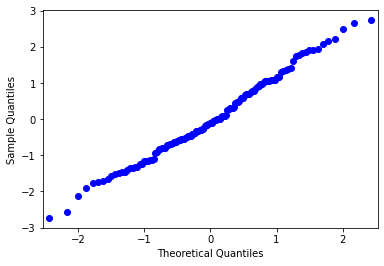

In [367]:
sm.qqplot(res.resid)
plt.show()

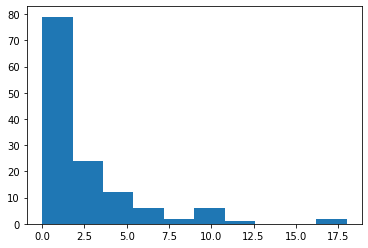

In [359]:
# plt.hist(np.log(participant_df['avg_message_tok'].values))
plt.hist(participant_df['num_error'].values)
plt.show()

# Cox Proportional Hazard Regression Model for "survival" duration in study
* How early first errors happen have effect on when the users leave.
* No interaction with phq8

In [79]:
# Make a helper variable that truncates the error for the number of turns seen
# before the participants first leaves. This only needs to happen when the 
# participant reported wanting to leave before seeing an error (20 cases?)

for i in participant_df.index:
    participant_df.loc[i, 'censored_first_error'] = np.min((participant_df.loc[i, 'left_after'], 
                                                      participant_df.loc[i, 'num_before_error']))

In [80]:
# status=0 indicates that the observation was right censored
participant_df['did_leave'] = ~np.isnan(participant_df['first_leave'])

ph_results = sm.PHReg.from_formula("left_after ~ C(Female) + Age + \
                avg_message_tok + mood_before + \
                phq8 * censored_first_error", status='did_leave', data=participant_df).fit()

print(ph_results.summary())

                                Results: PHReg
Model:                          PH Reg               Sample size:           132
Dependent variable:             left_after           Num. events:           95 
Ties:                           Breslow                                        
-------------------------------------------------------------------------------
                           log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-------------------------------------------------------------------------------
C(Female)[T.True]         -0.2639    0.2925 0.7681 -0.9020 0.3671 0.4329 1.3627
Age                       -0.0402    0.0590 0.9606 -0.6809 0.4959 0.8557 1.0784
avg_message_tok            0.0081    0.0264 1.0081  0.3064 0.7593 0.9572 1.0618
mood_before               -0.0461    0.0806 0.9550 -0.5717 0.5675 0.8154 1.1184
phq8                      -0.0181    0.0353 0.9821 -0.5109 0.6094 0.9164 1.0525
censored_first_error      -0.1130    0.0272 0.8932 -4.1577 0.0000 0.8469 

# Mixed-Effects model of decision to leave after each decision

Currently on hold. Can probably do with rpy2, but python's statsmodels doesn't have logisitc regression with mixed effects implemented yet, which I think is the right model for this task.


Notes on debugging singular fits: https://www.researchgate.net/post/What_does_singular_fit_mean_in_Mixed_Models

In [ ]:
# message_df['flow_index'] = message_df['Flow Index']

In [ ]:
# This is for mixed effects with linear models in statsmodels, but we need a logistic model, so may need R.
# me_results = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"], re_formula="~Time").fit()
# print(me_results)

In [ ]:
# want_to_leave ~ user_message_len + is_error + convo_had_error + response_strategy + flow_num + 
# phq8 + mood_before + is_helpful + gender + tfidf_message_specificity

## Reformat df for glmer: make df truncating when participant "left"

In [324]:
until_leave_fixed_df = []
message_fixed_df = []


for sona, df in message_df.groupby('sona'):
    
    s = 1 if df['Flow Index'].values[0] == 0 else 0 # NOTE: stripping off bot turn 0 when participant hasn't made a turn yet.
    
    message_fixed_df.append(df[s:]) 
    
    if sum(df['first_leave']) > 0:
        # truncate conversation when "participant left", i.e., at first leave
        # add 1 to index to include leaving
        df = df[:df['first_leave'].argmax() + 1]
    if df[s:].shape[0] == 0:
        print('wanted to leave from the start', sona)
        
    until_leave_fixed_df.append(df[s:])
    
message_fixed_df = pd.concat(message_fixed_df, axis=0)
until_leave_fixed_df = pd.concat(until_leave_fixed_df, axis=0)

wanted to leave from the start 41589
wanted to leave from the start 46933
wanted to leave from the start 49218
wanted to leave from the start 49857
wanted to leave from the start 50484


## Join with fixed effects: participant features

In [325]:
fixed_effects_df = participant_df[['sona', 'Female', 'Age',  
                                   'feel_bad', 'phq8', 'gad', 'mood_before',
                                   'why_first_leave_condensed', 'chatbot_experience']]
message_fixed_df = message_fixed_df.merge(fixed_effects_df, on='sona', how='left')
until_leave_fixed_df = until_leave_fixed_df.merge(fixed_effects_df, on='sona', how='left')

message_fixed_df['flow_index'] = message_fixed_df['Flow Index']
until_leave_fixed_df['flow_index'] = until_leave_fixed_df['Flow Index']


message_fixed_df['log_user_message_len'] = np.log(message_fixed_df['user_message_len'].values+.1)
until_leave_fixed_df['log_user_message_len'] = np.log(until_leave_fixed_df['user_message_len'].values)

## Write glmer dataframes to csv

In [326]:
message_fixed_df_filename = 'data/glmer_message_fixed.csv'
until_leave_fixed_df_filename = 'data/glmer_until_leave_fixed.csv'

message_fixed_df.to_csv(message_fixed_df_filename)
until_leave_fixed_df.to_csv(until_leave_fixed_df_filename)

### Import data to R

In [327]:
ro.r('library(lme4)')

ro.r('m_df <- read.csv("%s")' % message_fixed_df_filename)
ro.r('u_df <- read.csv("%s")' % until_leave_fixed_df_filename)
# ro.r('str(df)')

X,Unnamed..0,Flow.Index,...,chatbot_experience,flow_index,log_user_message_len
0,1,1,...,'True',1,0.000000
1,2,2,,'True',2,0.000000
2,3,3,,'True',3,0.000000
3,4,4,,'True',4,0.000000
...,...,...,,...,...,...
"1,915",4,4,,'True',4,2.944439
"1,916",5,5,,'True',5,0.000000
"1,917",6,6,,'True',6,1.791759
"1,918",7,7,,'True',7,3.091042


In [305]:
message_fixed_df.columns.values

array(['Unnamed: 0', 'Flow Index', 'User Message', 'Bot Response',
       'helpful', 'error', 'why_leave', 'helpful_bool', 'error_bool',
       'leave_bool', 'first_leave', 'first_error', 'user_message_len',
       'sona', 'cid', 'helpful_so_far', 'errors_so_far', 'strategy',
       'Female', 'Age', 'feel_bad', 'phq8', 'gad', 'mood_before',
       'why_first_leave_condensed', 'chatbot_experience', 'flow_index'],
      dtype=object)

### Convert releant var to factor

In [328]:
for l in ['m', 'u']:
    ro.r('''%s_df <- within(%s_df, {
  leave_bool <- factor(leave_bool, levels = c("False", "True"), labels = c("False", "True"))
  helpful_bool <- factor(helpful_bool, levels = c("False", "True"), labels = c("False", "True"))
  error_bool <- factor(error_bool, levels = c("False", "True"), labels = c("False", "True"))
  strategy <- factor(strategy)
  Female <- factor(Female)
  why_first_leave_condensed <- factor(why_first_leave_condensed)
  chatbot_experience <- factor(chatbot_experience)
  sona <- factor(sona)
})''' % (l, l))

In [329]:
ro.r('str(m_df)')

'data.frame':	3301 obs. of  29 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Unnamed..0               : int  1 2 3 4 5 6 7 1 2 3 ...
 $ Flow.Index               : int  1 2 3 4 5 6 7 1 2 3 ...
 $ User.Message             : chr  "Hi" "Good" "Yes" "Yes" ...
 $ Bot.Response             : chr  "How are you doing?" "I've heard that many people stay at home more often now due to COVID. Has that been the case for you?" "I see. I've also heard that many people's diets and exercise routines have changed while in quarantine. What ab"| __truncated__ "Ok. These last few months have been really difficult, and there's a lot going on in the world right now. Have y"| __truncated__ ...
 $ helpful                  : num  1 1 1 1 1 1 1 NA NA NA ...
 $ error                    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ why_leave                : chr  "na" "na" "na" "na" ...
 $ helpful_bool             : Factor w/ 2 levels "False","True": 2 2 2 2 2 2 2 1 1 1 ...
 $ error_bool    

<rpy2.rinterface_lib.sexp.NULLType object at 0x7ff0c8011230> [RTYPES.NILSXP]

In [330]:
ro.r('str(u_df)')

'data.frame':	1919 obs. of  29 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Unnamed..0               : int  1 2 3 4 5 6 7 1 2 3 ...
 $ Flow.Index               : int  1 2 3 4 5 6 7 1 2 3 ...
 $ User.Message             : chr  "Hi" "Good" "Yes" "Yes" ...
 $ Bot.Response             : chr  "How are you doing?" "I've heard that many people stay at home more often now due to COVID. Has that been the case for you?" "I see. I've also heard that many people's diets and exercise routines have changed while in quarantine. What ab"| __truncated__ "Ok. These last few months have been really difficult, and there's a lot going on in the world right now. Have y"| __truncated__ ...
 $ helpful                  : num  1 1 1 1 1 1 1 NA NA NA ...
 $ error                    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ why_leave                : chr  "na" "na" "na" "na" ...
 $ helpful_bool             : Factor w/ 2 levels "False","True": 2 2 2 2 2 2 2 1 1 1 ...
 $ error_bool    

<rpy2.rinterface_lib.sexp.NULLType object at 0x7ff0c8011230> [RTYPES.NILSXP]

In [193]:
message_df.columns.values

array(['Unnamed: 0', 'Flow Index', 'User Message', 'Bot Response',
       'helpful', 'error', 'why_leave', 'helpful_bool', 'error_bool',
       'leave_bool', 'first_leave', 'first_error', 'user_message_len',
       'sona', 'cid', 'helpful_so_far', 'errors_so_far', 'strategy'],
      dtype=object)

In [194]:
message_fixed_df.columns.values

array(['Unnamed: 0', 'Flow Index', 'User Message', 'Bot Response',
       'helpful', 'error', 'why_leave', 'helpful_bool', 'error_bool',
       'leave_bool', 'first_leave', 'first_error', 'user_message_len',
       'sona', 'cid', 'helpful_so_far', 'errors_so_far', 'strategy',
       'Female', 'Age', 'feel_bad', 'phq8', 'gad', 'mood_before',
       'why_first_leave_condensed', 'chatbot_experience'], dtype=object)

## Declare fixed effects for every model: participant characteristics

In [197]:
fixed_effects_str = 'Female + Age + feel_bad + mood_before + chatbot_experience'

## glmer: Influences on leaving every turn

Note: Include tfidf_specificity of user's last message?

In [343]:
# want_to_leave ~ user_message_len + is_error + convo_had_error + response_strategy + flow_num + 
# phq8 + mood_before + is_helpful + gender + tfidf_message_specificity

# rand_effects_str = 'flow_index + helpful_so_far + errors_so_far + error_bool + user_message_len + strategy'

fixed_effects_str = 'Female + Age + feel_bad + mood_before + chatbot_experience + flow_index + helpful_so_far + errors_so_far + error_bool + log_user_message_len + strategy'
rand_effects_str = '1 + flow_index + log_user_message_len'


ro.r('''m <- glmer(leave_bool ~ %s + (%s| sona), 
    data = m_df, family = binomial, 
    control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=2e5)),
    nAGQ = 1)''' % (fixed_effects_str, rand_effects_str))

# print summary formatted
print(ro.r('summary(m)'))

Correlation matrix not shown by default, as p = 15 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
leave_bool ~ Female + Age + feel_bad + mood_before + chatbot_experience +  
    flow_index + helpful_so_far + errors_so_far + error_bool +  
    log_user_message_len + strategy + (1 + flow_index + log_user_message_len |  
    sona)
   Data: m_df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  1599.4   1727.5   -778.7   1557.4     3280 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9618 -0.2344 -0.1165 -0.0584  7.7076 

Random effects:
 Groups Name                 Variance Std.Dev. Corr       
 sona   (Intercept)          3.274181 1.80947             
        flow_index           0.009699 0.09849  -0.16      
        log_user_message_len 0.107911 0.32850   0.30 -0.74
Number of obs: 3301, groups:  sona, 132

Fixed effects:
                         Estimate Std. Er

## glmer: Influences on first leave--early termination

In [371]:
fixed_effects_str = 'Female + Age + feel_bad + mood_before + chatbot_experience + flow_index + helpful_so_far \
+ error_bool + log_user_message_len + strategy'

rand_effects_str = '1'

ro.r('''u <- glmer(leave_bool ~ %s + (%s| sona), 
    data = u_df, family = binomial,
    control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=2e5)),
    nAGQ = 1)''' % (fixed_effects_str, rand_effects_str))

# control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=2e5)),

# print summary formatted
print(ro.r('summary(u)'))

Correlation matrix not shown by default, as p = 14 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
leave_bool ~ Female + Age + feel_bad + mood_before + chatbot_experience +  
    flow_index + helpful_so_far + error_bool + log_user_message_len +  
    strategy + (1 | sona)
   Data: u_df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
   596.7    680.1   -283.4    566.7     1904 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8429 -0.1650 -0.0964 -0.0574  7.3282 

Random effects:
 Groups Name        Variance Std.Dev.
 sona   (Intercept) 3.5      1.871   
Number of obs: 1919, groups:  sona, 127

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -8.58272    3.31146  -2.592 0.009547 ** 
FemaleTrue                1.01145    0.65073   1.554 0.120107    
Age                       0.15451    0.14846   1.041 0.298005

In [248]:
# print(ro.r('summary(u, correlation=TRUE)'))

In [221]:
# print(ro.r('u_df[,"Flow.Index"]'))

## glmer: Influences on being helpful

In [370]:

fixed_effects_str = 'Female + Age + feel_bad + mood_before + chatbot_experience + flow_index + helpful_so_far + error_bool + log_user_message_len + strategy'

rand_effects_str = '1'

ro.r('''h <- glmer(helpful_bool ~ %s + (%s| sona), 
    data = m_df, family = binomial,
    control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=2e5)),
    nAGQ = 1)''' % (fixed_effects_str, rand_effects_str))

# print summary formatted
print(ro.r('summary(h)'))

Correlation matrix not shown by default, as p = 14 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
helpful_bool ~ Female + Age + feel_bad + mood_before + chatbot_experience +  
    flow_index + helpful_so_far + error_bool + log_user_message_len +  
    strategy + (1 | sona)
   Data: m_df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  1909.8   2001.3   -939.9   1879.8     3286 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-18.7425  -0.2553  -0.0288   0.1399  10.2190 

Random effects:
 Groups Name        Variance Std.Dev.
 sona   (Intercept) 5.603    2.367   
Number of obs: 3301, groups:  sona, 132

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.33386    3.11599   0.428  0.66860    
FemaleTrue                0.34536    0.60320   0.573  0.56696    
Age                      -0.08785    0.14678  -0.

### TODO: 
* Change strategy factor variable so that neutral is the base and we can look at active_listening effect.
* Interpret models
* Decide on all or first_leave only